In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.special import sph_harm
import pickle  # For saving and loading data
import os      # For file operations

In [2]:
def trigonometric_cache(theta, phi):
    s_theta = np.sin(theta)
    c_theta = np.cos(theta)
    s_phi = np.sin(phi)
    c_phi = np.cos(phi)
    return s_theta, c_theta, s_phi, c_phi


In [3]:
def pulsar_geometry_terms(xvec, theta, phi, trig_cache):
    s_theta, c_theta, s_phi, c_phi = trig_cache
    
    omega_hat = np.array([s_theta * c_phi, s_theta * s_phi, c_theta])
    m_hat = np.array([s_phi, -c_phi, 0])
    n_hat = np.array([c_theta * c_phi, c_theta * s_phi, -s_theta])
    
    e_plus = np.outer(m_hat, m_hat) - np.outer(n_hat, n_hat)
    e_cross = np.outer(m_hat, n_hat) + np.outer(n_hat, m_hat)
    
    pulsar = 0.5 * np.outer(xvec, xvec)
    
    f_plus = np.dot(e_plus, pulsar)
    f_cross = np.dot(e_cross, pulsar)
    
    denom = 1 + np.dot(omega_hat, xvec) + 1e-10  # Avoid division by zero
    
    d_plus = np.trace(f_plus / denom)
    d_cross = np.trace(f_cross / denom)
    
    factor = d_plus ** 2 + d_cross ** 2
    
    return d_plus, d_cross, factor


In [4]:
def integrand_circular_ylm(theta, phi, xvec, xve2_i, l, m):
    trig_cache = trigonometric_cache(theta, phi)
    d_plus_xvec, d_cross_xvec, _ = pulsar_geometry_terms(xvec, theta, phi, trig_cache)
    d_plus_xve2, d_cross_xve2, _ = pulsar_geometry_terms(xve2_i, theta, phi, trig_cache)
    
    # Spherical harmonic function Y_l^m(θ, φ)
    y_lm = sph_harm(m, l, phi, theta)  # Note: sph_harm(m, l, phi, theta)
    
    # Compute the integrand
    integrand = -1j * y_lm * (d_plus_xvec * d_cross_xve2 - d_cross_xvec * d_plus_xve2) * np.sin(theta) / (4 * np.pi)
    
    # Since we're integrating over real variables, return the real part
    return np.real(integrand)


In [5]:
def integrand_intensity_ylm(theta, phi, xvec, xve2_i, l, m):
    trig_cache = trigonometric_cache(theta, phi)
    d_plus_xvec, d_cross_xvec, _ = pulsar_geometry_terms(xvec, theta, phi, trig_cache)
    d_plus_xve2, d_cross_xve2, _ = pulsar_geometry_terms(xve2_i, theta, phi, trig_cache)
    
    # Spherical harmonic function Y_l^m(θ, φ)
    y_lm = sph_harm(m, l, phi, theta)  # Note: sph_harm(m, l, phi, theta)
    
    # Compute the integrand
    integrand =  y_lm * (d_plus_xvec * d_plus_xve2 + d_cross_xvec * d_cross_xve2) * np.sin(theta) / (4 * np.pi)
    
    # Since we're integrating over real variables, return the real part
    return np.real(integrand)

In [6]:
# Define the pulsar vector
xvec = np.array([0, 0, 1])

# Define the list of Xi values
Xi = np.linspace(0, np.pi, 61)  # 61 points from 0 to π

# Generate corresponding vectors xve2 for each Xi value
xve2 = [np.array([np.sin(xi), 0, np.cos(xi)]) for xi in Xi]


In [7]:
# Define the filename for saving the result
filename1 = 'result_circular_polarization_ylm.pkl'

# Check if the file already exists
if not os.path.exists(filename1):
    print("File not found. Running the calculations...")
    
    # Compute the result for circular polarization with spherical harmonics
    result_circular_polarization_ylm = []

    # Loop over xi values, l, and m
    for i in range(len(xve2)):
        intensity_lm = []
        for l in range(4):  # l from 0 to 3
            intensity_m = []
            for m in range(-l, l + 1):
                # Perform the integration over theta and phi
                res, _ = nquad(
                    integrand_circular_ylm,
                    [[0, np.pi], [0, 2 * np.pi]],
                    args=(xvec, xve2[i], l, m)
                )
                intensity_m.append(res)
            intensity_lm.append(intensity_m)
        result_circular_polarization_ylm.append(intensity_lm)
    
    # Save the result to a file using pickle
    with open(filename1, 'wb') as f:
        pickle.dump(result_circular_polarization_ylm, f)
    print(f"Calculation complete. Data saved to {filename1}")
else:
    # If the file exists, load the saved data
    with open(filename1, 'rb') as f:
        result_circular_polarization_ylm = pickle.load(f)
    print(f"Data loaded from {filename1}")


Data loaded from result_circular_polarization_ylm.pkl


In [8]:
# Define the filename for saving the result
filename2 = 'result_intensity_ylm.pkl'

# Check if the file already exists
if not os.path.exists(filename2):
    print("File not found. Running the calculations...")
    
    # Compute the result for intensity  with spherical harmonics
    result_intensity_ylm = []

    # Loop over xi values, l, and m
    for i in range(len(xve2)):
        intensity_lm = []
        for l in range(4):  # l from 0 to 3
            intensity_m = []
            for m in range(-l, l + 1):
                # Perform the integration over theta and phi
                res, _ = nquad(
                    integrand_intensity_ylm,
                    [[0, np.pi], [0, 2 * np.pi]],
                    args=(xvec, xve2[i], l, m)
                )
                intensity_m.append(res)
            intensity_lm.append(intensity_m)
        result_intensity_ylm.append(intensity_lm)
    
    # Save the result to a file using pickle
    with open(filename2, 'wb') as f:
        pickle.dump(result_intensity_ylm, f)
    print(f"Calculation complete. Data saved to {filename2}")
else:
    # If the file exists, load the saved data
    with open(filename2, 'rb') as f:
        result_intensity_ylm = pickle.load(f)
    print(f"Data loaded from {filename2}")


Data loaded from result_intensity_ylm.pkl


In [9]:
def plot_ylm(data_ylm, data_xi, ylabel):
    num_xi = len(data_xi)
    l_max = len(data_ylm[0]) - 1
    xi_values = data_xi

   
    for l in range(0, l_max ):  # Exclude l=0
        plt.figure(figsize=(8, 6))
        # For each m in l, plot on the same axes
        for m in range(-l, l + 1):
            data = []
            for i in range(num_xi):
                try:
                    data_point = data_ylm[i][l][m + l]
                    data.append(data_point)
                except IndexError as e:
                    print(f"IndexError at i={i}, l={l}, m={m}: {e}")
                    # Handle the error, e.g., append a default value or skip
                    data.append(0.0)
            # Plot data
            plt.plot(xi_values, data, label=f'm = {m}')
        plt.xlabel(r'$\Xi$')
        plt.ylabel(ylabel)
        plt.title(f'Plot for l = {l}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


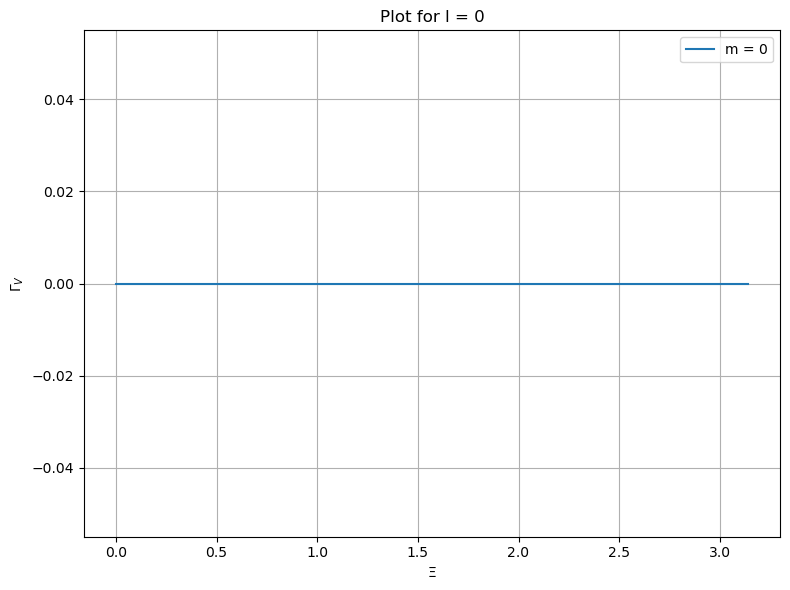

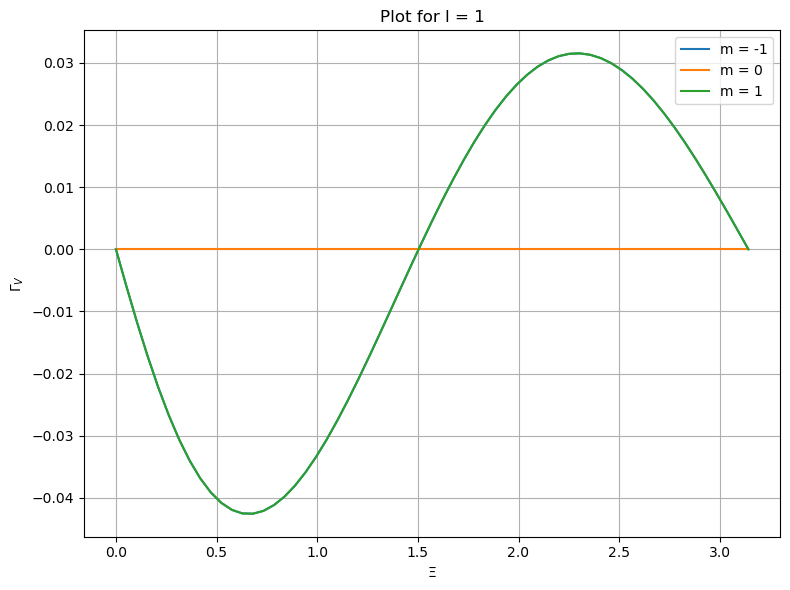

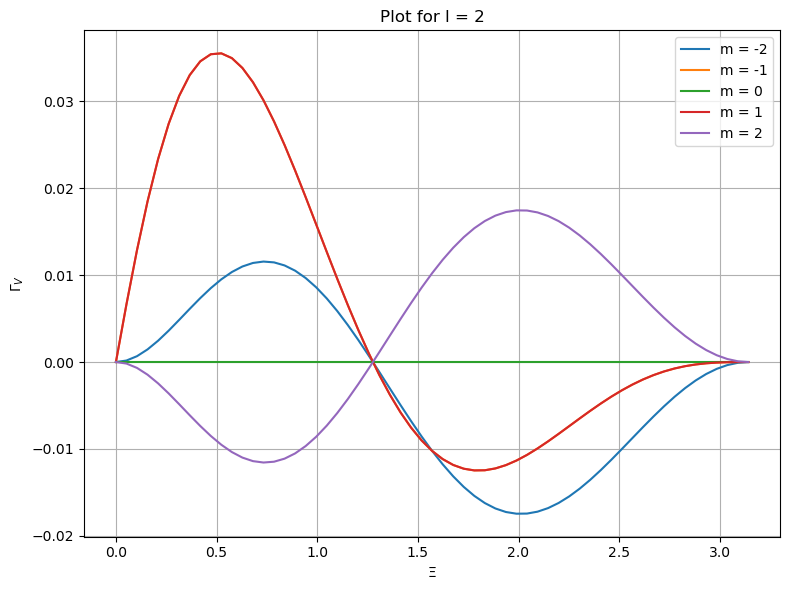

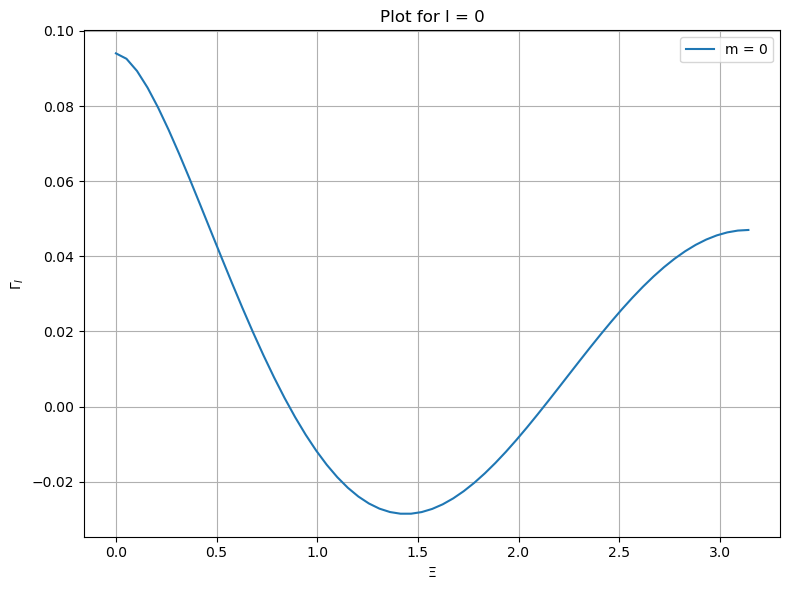

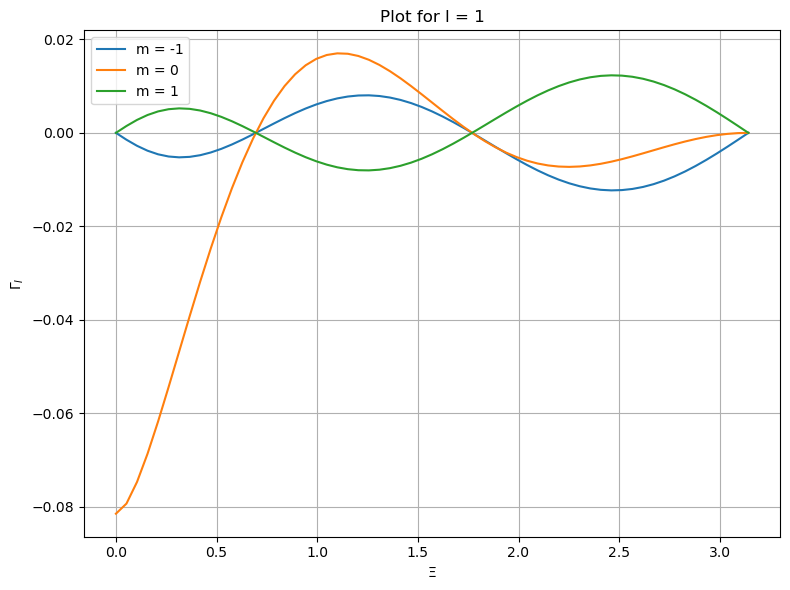

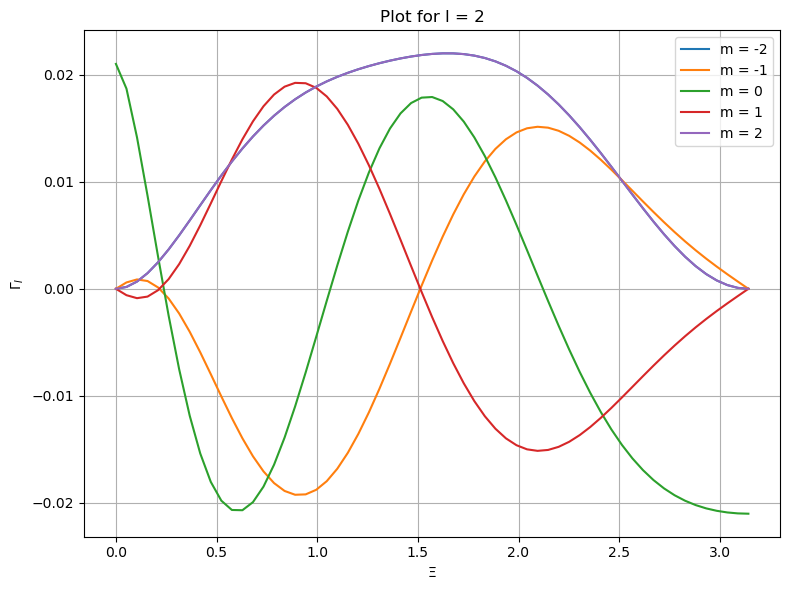

In [10]:
# Plot the results
plot_ylm(result_circular_polarization_ylm, Xi,r"$\Gamma_V$")
plot_ylm(result_intensity_ylm,Xi,r"$\Gamma_I$")


## Alternative polarizations

In [11]:
import numpy as np

# Define the functions
def R1_plus(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_plus with an option to include or exclude frequency terms.
    """
    exponent = -2j * np.pi * f * L1 * (1 + np.cos(theta)) / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0  # Set exp_term to zero when frequency is excluded
    return 0.5 * (1 - np.cos(theta)) * (1 - exp_term)

def R2_plus(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_plus with an option to include or exclude frequency terms.
    """
    term1 = 1 - np.sin(zeta) * np.sin(theta) * np.cos(phi) - np.cos(theta) * np.cos(zeta)
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    term2 = (2 * np.sin(zeta)**2 * np.sin(phi)**2) / denominator
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0  # Set exp_term to zero when frequency is excluded
    return 0.5 * term1 * term2 * (1 - exp_term)

def R1_X(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_X. This function always returns zero.
    """
    return 0

def R2_X(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_X with an option to include or exclude frequency terms.
    """
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    numerator = (np.sin(zeta)**2 * np.cos(theta) * np.sin(2 * phi)
                 - np.sin(2 * zeta) * np.sin(theta) * np.sin(phi))
    term1 = numerator / denominator
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0  # Set exp_term to zero when frequency is excluded
    return 0.5 * term1 * (1 - exp_term)

def R1_B(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_B with an option to include or exclude frequency terms.
    """
    exponent = -2j * np.pi * f * L1 * (1 + np.cos(theta)) / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    return 0.5 * (1 - np.cos(theta)) * (1 - exp_term)

def R2_B(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_B with an option to include or exclude frequency terms.
    """
    term1 = 1 - np.sin(zeta) * np.sin(theta) * np.cos(phi) - np.cos(theta) * np.cos(zeta)
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    return 0.5 * term1 * (1 - exp_term)

def R1_L(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_L with an option to include or exclude frequency terms.
    """
    exponent = -2j * np.pi * f * L1 * (1 + np.cos(theta)) / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    numerator = np.cos(theta)**2
    denominator = np.sqrt(2) * (1 + np.cos(theta))
    return (numerator / denominator) * (1 - exp_term)

def R2_L(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_L with an option to include or exclude frequency terms.
    """
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    numerator = (np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta))**2
    term2 = np.sqrt(2) * denominator
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    return (numerator / term2) * (1 - exp_term)

def R1_X_1(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_X_1 with an option to include or exclude frequency terms.
    """
    exponent = -2j * np.pi * f * L1 * (1 + np.cos(theta)) / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    numerator = -np.cos(theta) * np.sin(theta)
    denominator = 1 + np.cos(theta)
    return (numerator / denominator) * (1 - exp_term)

def R2_X_1(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_X_1 with an option to include or exclude frequency terms.
    """
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    term1 = np.sin(theta) * np.sin(zeta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    numerator = np.cos(theta) * np.sin(theta) - np.sin(theta) * np.cos(zeta)
    term2 = numerator / denominator
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    return term1 * term2 * (1 - exp_term)

def R1_Y(f,  theta, L1, c=1, include_frequency=False):
    """
    Function to calculate R1_Y. This function always returns zero.
    """
    return 0

def R2_Y(f,  theta, phi, zeta, L2, c=1, include_frequency=False):
    """
    Function to calculate R2_Y with an option to include or exclude frequency terms.
    """
    denominator = 1 + np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    term1_numerator = -np.sin(phi) * np.sin(theta) * (
        np.sin(zeta) * np.sin(theta) * np.cos(phi) + np.cos(theta) * np.cos(zeta)
    )
    term1 = term1_numerator / denominator
    exponent = -2j * np.pi * f * L2 * denominator / c
    if include_frequency:
        exp_term = np.exp(exponent)
    else:
        exp_term = 0
    return term1 * (1 - exp_term)


In [12]:
def integrand_ylm(theta, phi, xi, l, m, func1, func2, Label="Intensity"):
    # Spherical harmonic function Y_l^m(θ, φ)
    y_lm = sph_harm(m, l, phi, theta)
    
    # Since zeta = xi
    zeta = xi
    
    # Compute R1 and R2 with the provided functions
    R1 = func1(f=1, theta=theta, L1=1)  # Use default c=1, include_frequency=False
    R2 = func2(f=1, theta=theta, phi=phi, zeta=zeta, L2=1)  # Use default c=1, include_frequency=False
    
    # Compute the integrand
    integrand = y_lm * R1 * np.conj(R2) * np.sin(theta) / (4 * np.pi)
    
    # Return the real part
    return np.real(integrand)

# Define the filename for saving the result
filename = 'result_plus_polarization_ylm.pkl'

# Define the functions for R1 and R2
func1 = R1_plus
func2 = R2_plus
def integral_calculation(func1,func2,Label,filename):
    # Check if the file already exists
    if not os.path.exists(filename):
        print("File not found. Running the calculations...")

        # Initialize result list
        result_plus_polarization_ylm = []

        for xi_index, xi in enumerate(Xi):
            intensity_lm = []
            for l in range(4):  # l from 0 to 3
                intensity_m = []
                for m in range(-l, l + 1):
                    try:
                        # Perform the integration over theta and phi
                        res, _ = nquad(
                            integrand_ylm,
                            [[0, np.pi], [0, 2 * np.pi]],
                            args=(xi, l, m, func1, func2,Label)
                        )
                        if not np.isfinite(res):
                            print(f"Non-finite result at xi_index={xi_index}, xi={xi}, l={l}, m={m}. Setting res to 0.")
                            res = 0.0
                    except Exception as e:
                        print(f"Integration failed at xi_index={xi_index}, xi={xi}, l={l}, m={m} with error: {e}")
                        res = 0.0  # Assign a default value or handle as needed
                    intensity_m.append(res)
                # Check if intensity_m has the expected length
                expected_length = 2 * l + 1
                actual_length = len(intensity_m)
                if actual_length != expected_length:
                    print(f"Length mismatch at xi_index={xi_index}, xi={xi}, l={l}: expected {expected_length}, got {actual_length}")
                intensity_lm.append(intensity_m)
            # Check if intensity_lm has the expected number of l levels
            if len(intensity_lm) != 4:
                print(f"Length mismatch in intensity_lm at xi_index={xi_index}: expected 4, got {len(intensity_lm)}")
            result_plus_polarization_ylm.append(intensity_lm)

        # Save the result to a file using pickle
        with open(filename, 'wb') as f:
            pickle.dump(result_plus_polarization_ylm, f)
        print(f"Calculation complete. Data saved to {filename}")
    else:
        # If the file exists, load the saved data
        with open(filename, 'rb') as f:
            result_plus_polarization_ylm = pickle.load(f)
        print(f"Data loaded from {filename}")
        return result_plus_polarization_ylm


In [24]:
#Calculating all the ORF and wrinting them to files
plus_ylm = integral_calculation(R1_plus,R2_plus,"Plus","plus_ylm.plk")
cross_ylm = integral_calculation(R1_X,R2_X,"Cross","cross_ylm.plk")
#breathing_ylm = integral_calculation(R1_B,R2_B,"Plus","breathing_ylm.plk")
longitudinal_ylm = integral_calculation(R1_L,R2_L,"Plus","longitudinal_ylm.plk")
#vector_longitudinal_x_ylm = integral_calculation(R1_X_1,R2_X_1,"Plus","vector_longitudinal_x_ylm.plk")
#vector_longitudinal_y_ylm = integral_calculation(R2_Y,R2_Y,"Plus","vector_longitudinal_y_ylm.plk")




Data loaded from plus_ylm.plk
Data loaded from cross_ylm.plk
File not found. Running the calculations...


/home/mgurgeni/anaconda3/envs/enterprise/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/tmp/ipykernel_23433/2068060888.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  return (numerator / denominator) * (1 - exp_term)
/tmp/ipykernel_23433/2068060888.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  return (numerator / term2) * (1 - exp_term)
/tmp/ipykernel_23433/1921059791.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  integrand = y_lm * R1 * np.conj(R2) * np.sin(theta) / (4 * np.pi)
/home/mgurgeni/anaconda3/envs/enterprise/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in

Non-finite result at xi_index=0, xi=0.0, l=2, m=-2. Setting res to 0.
Non-finite result at xi_index=0, xi=0.0, l=2, m=2. Setting res to 0.
Non-finite result at xi_index=0, xi=0.0, l=3, m=-2. Setting res to 0.
Non-finite result at xi_index=0, xi=0.0, l=3, m=2. Setting res to 0.
Non-finite result at xi_index=1, xi=0.05235987755982988, l=0, m=0. Setting res to 0.


/home/mgurgeni/anaconda3/envs/enterprise/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Non-finite result at xi_index=1, xi=0.05235987755982988, l=1, m=0. Setting res to 0.
Non-finite result at xi_index=1, xi=0.05235987755982988, l=2, m=0. Setting res to 0.
Non-finite result at xi_index=1, xi=0.05235987755982988, l=3, m=0. Setting res to 0.


KeyboardInterrupt: 

In [14]:
Xi.shape
len(xve2)

61

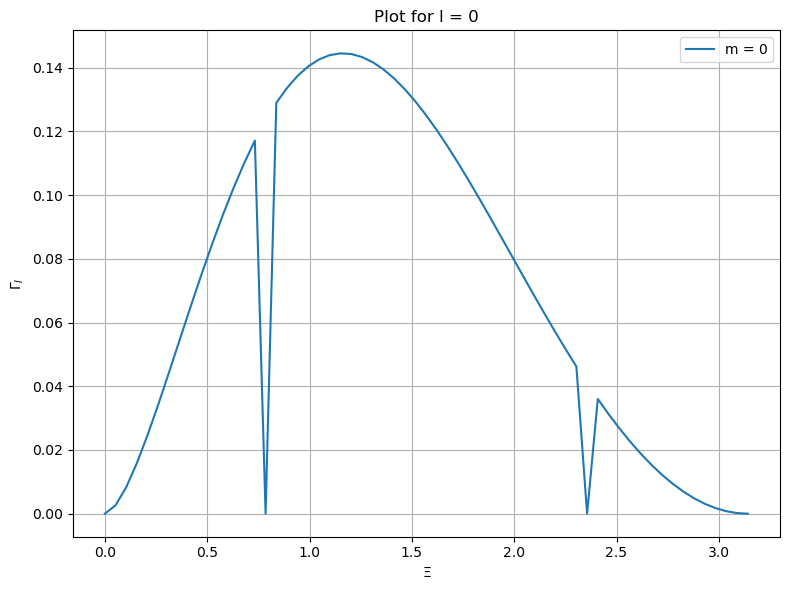

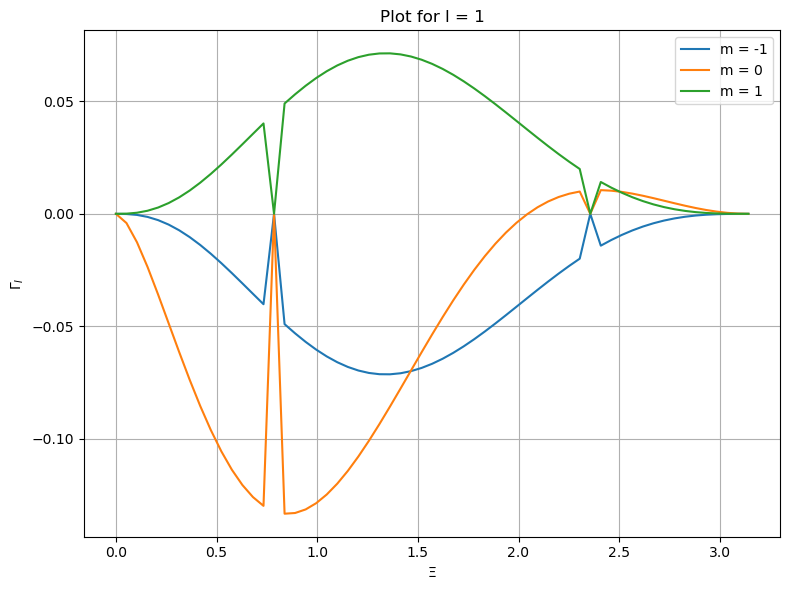

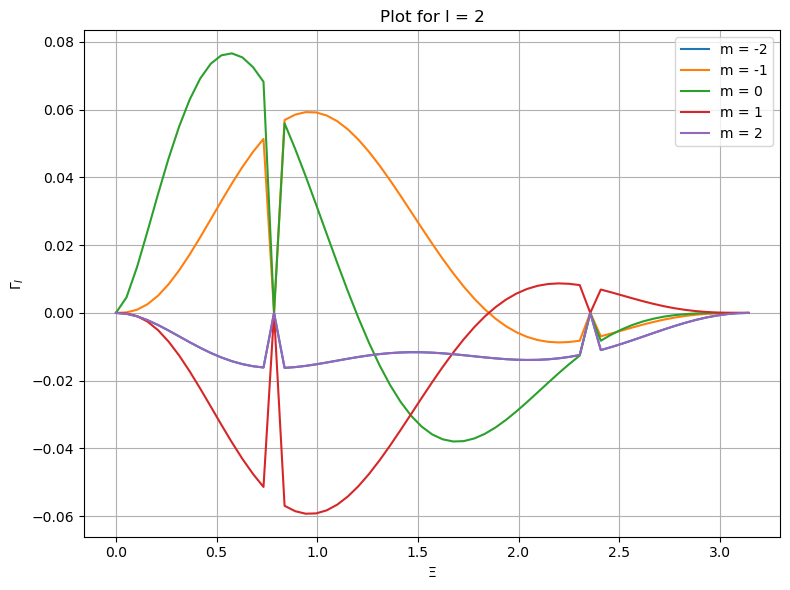

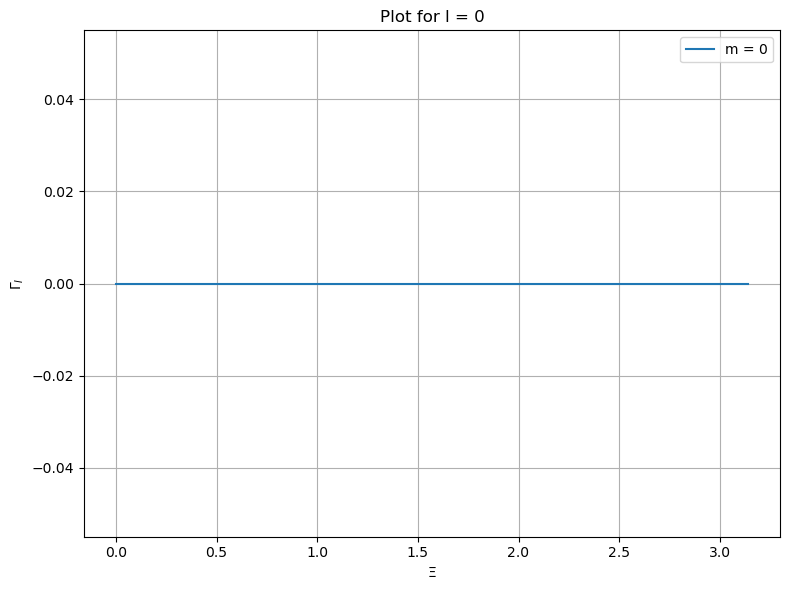

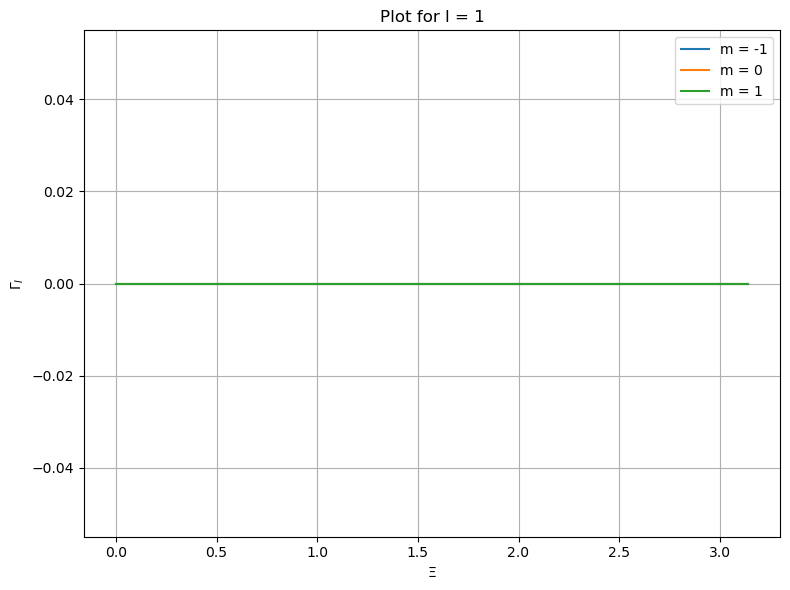

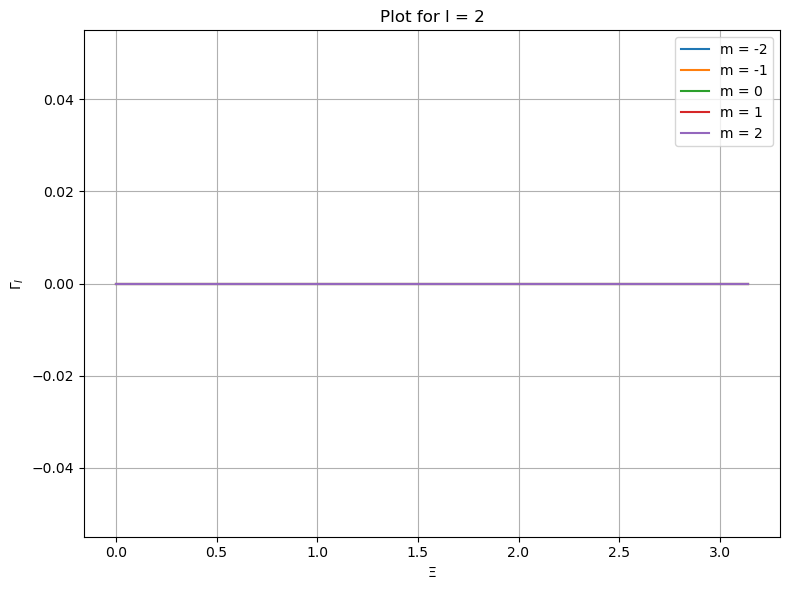

In [23]:
plot_ylm(plus_ylm,Xi,r"$\Gamma_I$")
plot_ylm(cross_ylm,Xi,r"$\Gamma_I$")